## Setup


We first had to request access to LLAMA-2 at HuggingFace, and thus have to be logged in.

Run the following command locally to login:

!huggingface-cli login

In [ ]:
## check if you are logged in
!huggingface-cli whoami

saskialaora


In [ ]:
## load data
import pandas as pd

db = pd.read_csv('raw_data.csv', index_col='Unnamed: 0')

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
# explore data
pd.set_option('display.max_colwidth', 30)
db.head(2)

Authors              Author full names  \
0  Symeonidis P.; Tiakas E.; ...  Symeonidis, Panagiotis (13...   
1  Kisilevich S.; Ang C.S.; L...  Kisilevich, Slava (2339286...   

                    Author(s) ID                          Title  Year  \
0  13006105800; 23668927700; ...  Transitive node similarity...  2010   
1  23392866000; 15831174100; ...  Large-scale analysis of se...  2012   

                    Source title                        DOI  \
0  ACM Conference on Recommen...    10.1145/1864708.1864744   
1  Knowledge and Information ...  10.1007/s10115-011-0443-z   

                            Link                   Affiliations  \
0  https://www.scopus.com/inw...  Department of Informatics,...   
1  https://www.scopus.com/inw...  Department of Computer and...   

       Authors with affiliations                       Abstract  \
0  Symeonidis P., Department ...  Online social networks (OS...   
1  Kisilevich S., Department ...  Online social network serv...   

                 Author Keywords Funding Details Funding Texts  \
0    Algorithms; Experimentation             NaN           NaN   
1  Age differences; Clusterin...             NaN           NaN   

  Language of Original Document       Abbreviated Source Title  \
0                       English  RecSys - Proc. ACM Conf. R...   
1                       English     Knowl. Inf. Systems. Syst.   

                       OSN  
0  ['Facebook', 'Myspace']  
1             ['Facebook']

In [ ]:
#check for duplicates
db[db.duplicated(subset='Abstract', keep=False)]

Authors              Author full names  \
449   Martin T.; Hofman J.M.; Sh...  Martin, Travis (5719724917...   
1541  Savenkov D.; Braslavski P....  Savenkov, Denis (523649336...   
1577  Elenberg E.R.; Borokhovich...  Elenberg, Ethan R. (563531...   
6034  Leong C.W.; Hassan S.; Rui...  Leong, Chee Wee (564502925...   

                       Author(s) ID                          Title  Year  \
449   57197249174; 14044894200; ...  Exploring limits to predic...  2016   
1541  52364933600; 16548847400; ...  Search snippet evaluation ...  2011   
1577  56353141800; 27567609600; ...  Distributed Estimation of ...  2016   
6034  56450292500; 57211566138; ...  Improving query expansion ...  2011   

                       Source title                           DOI  \
449              ACM Web Conference       10.1145/2872427.2883001   
1541  Lecture Notes in Computer ...   10.1007/978-3-642-23708-9_4   
1577             ACM Web Conference       10.1145/2872427.2883082   
6034  Lecture Notes in Computer ...  10.1007/978-3-642-23708-9_16   

                               Link                   Affiliations  \
449   https://www.scopus.com/inw...  University of Michigan, De...   
1541  https://www.scopus.com/inw...  Yandex, Moscow 119021, 16,...   
1577  https://www.scopus.com/inw...  University of Texas, Austi...   
6034  https://www.scopus.com/inw...  Department of Computer Sci...   

          Authors with affiliations                       Abstract  \
449   Martin T., University of M...  How predictable is success...   
1541  Savenkov D., Yandex, Mosco...  In this paper, we present ...   
1577  Elenberg E.R., University ...  How predictable is success...   
6034  Leong C.W., Department of ...  In this paper, we present ...   

                    Author Keywords                Funding Details  \
449                             NaN                            NaN   
1541  evaluation; experimentatio...                            NaN   
1577                            NaN  Directorate for Computer a...   
6034                            NaN                            NaN   

     Funding Texts Language of Original Document  \
449            NaN                       English   
1541           NaN                       English   
1577           NaN                       English   
6034           NaN                       English   

           Abbreviated Source Title            OSN  
449   Int. World Wide Web Conf.,...    ['Twitter']  
1541       Lect. Notes Comput. Sci.  ['Wikipedia']  
1577  Int. World Wide Web Conf.,...    ['Twitter']  
6034       Lect. Notes Comput. Sci.  ['Wikipedia']

In [ ]:
#remove dupliactes
# the paper with the title "Improving query expansion for image retrieval via Saliency and Picturability" has the wrong abstract on Springer" index: 6034
# same for this paper "Distributed Estimation of Graph 4-Profiles" index: 1577

db = db.drop(index=6034)
db = db.drop(index=1577)

In [ ]:
#check for duplicates
db[db.duplicated(subset='Abstract', keep=False)]

Empty DataFrame
Columns: [Authors, Author full names, Author(s) ID, Title, Year, Source title, DOI, Link, Affiliations, Authors with affiliations, Abstract, Author Keywords, Funding Details, Funding Texts, Language of Original Document, Abbreviated Source Title, OSN]
Index: []

In [ ]:
print(f"Total number of papers in our db: {len(db)}")

Total number of papers in our db: 12186


In [ ]:
#prepare data
abstracts = db.Abstract.tolist()
titles = db['Title'].tolist()

## Llama 2

In [ ]:
from torch import cuda

model_id = 'meta-llama/Llama-2-7b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


In [ ]:
## for local setup: "pip install bitsandbytes"

from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16  # Computation type
)

/home/das/anaconda3/envs/twitter-6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.

In [ ]:
import accelerate
import bitsandbytes

In [ ]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',
)
model.eval()

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:01<00:00,  1.04it/s]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [ ]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1
)

### Prompt engineering

In [ ]:
prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you explain to me how 4-bit quantization works as if I am 5?
 nobody likes a know-it-all, but sometimes it's necessary to explain things in simple terms.

So, imagine you have a big box of candy, and inside that box, there are lots of different types of candy, like gummies, peanut butter cups, and licorice. Now, instead of having all those different types of candy in the box, we want to make it simpler. So, we take a special tool called a "quantizer" and we use it to group all the different types of candy into just four groups: red, green, blue, and yellow.

But here's the magic part: even though we're only using four groups, our brain can still see all the different types of candy! It's like, even though we're only using four colors to paint a picture, our brain can still see all the different shapes and details in the picture.

So, when we look at something that's been quantized, like an image that's been compressed into 4 bits, our brain can still recognize all the different d

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our user prompt is going to the be a bit more involved. It will consist of two components, an example and the main prompt.

Let's start with the example. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [ ]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

In [ ]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

In [ ]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

In [ ]:
prompt = system_prompt + example_prompt + main_prompt

## BertTopic

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en-v1.5")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

Batches: 100%|████████████████████████████████| 381/381 [00:28<00:00, 13.17it/s]


We experimented with the following sentence model: "bge-small-en" and "all-mpnet-base-v2"

For umap **n_components** balances local vs global structure in the data.

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=200, min_samples= 10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

**Details on HDBSCAN parameters can be found here:** https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

**min_cluster_size:** Most important parameter in HDBSCAN: controls the minimum size of a cluster and thereby the number of clusters that will be generated. It is set to 10 as a default. Increasing this value results in fewer clusters but of larger size whereas decreasing this value results in more micro clusters being generated. Rather increase this value than decrease it.

**min_samples:** min_samples is automatically set to min_cluster_size and controls the number of outliers generated. Setting this value significantly lower than min_cluster_size might help you reduce the amount of noise you will get. Do note that outliers are to be expected and forcing the output to have no outliers may not properly represent the data.

In [ ]:
# pre-reduce embeddings for visualization purposes; this does not change the output but only the representation
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

/home/das/anaconda3/envs/twitter-6/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/das/anaconda3/envs/twitter-6/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning:

The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#remove stopwords at the CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and KeyBERT, MMR, and Llama 2 as additional representations.

MMR (Maximal Marginal Relevance) additionally considers the similarity of keywords in the representation, e.g. avoiding words like "car" and "cars" in the representation since it is redunant information.

In [ ]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MaxMarginalRelevance (MMR) can be fine-tuned to diversify the words representing a topic (by limiting the number of duplicate words in a topic)
# diversity can be specified between 0 and 1; with 0 not being diverse at all and 1 being completely diverse
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

**Hyperparameter Tuning Details:** https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html

**top_n_words**= number of words per topic that you want to be extracted (keep below 30 and preferably between 10 and 20).

**min_topic_size** = specify minimum size of a topic; the lower this value the more topics are created (default = 10); if you got almost a million documents, then it is advised to set it much higher than the default of 10, for example, 100 or even 500.

**nr_topics** =  specifies, after training the topic model, the number of topics that will be reduced. For example, if your topic model results in 100 topics but you have set nr_topics to 20 then the topic model will try to reduce the number of topics from 100 to 20.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  vectorizer_model=vectorizer_model,
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=20,
  min_topic_size=50,
  nr_topics="auto",
  verbose=True,
  calculate_probabilities=True
)

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings)

2024-04-23 22:33:20,002 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-23 22:33:26,276 - BERTopic - Dimensionality - Completed ✓
2024-04-23 22:33:26,277 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-23 22:33:27,171 - BERTopic - Cluster - Completed ✓
2024-04-23 22:33:27,172 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|███████████████████████████████████████████| 18/18 [00:14<00:00,  1.25it/s]
2024-04-23 22:33:45,219 - BERTopic - Representation - Completed ✓
2024-04-23 22:33:45,220 - BERTopic - Topic reduction - Reducing number of topics
100%|███████████████████████████████████████████| 18/18 [00:14<00:00,  1.22it/s]
2024-04-23 22:34:03,598 - BERTopic - Topic reduction - Reduced number of topics from 18 to 18


In [ ]:
# explore topics
pd.set_option('display.max_colwidth', 50)
topic_model.get_topic_info()

Topic  Count                                         Name  \
0      -1   2123                    -1_social_data_users_user   
1       0   1462        0_wikipedia_knowledge_entity_entities   
2       1   1128             1_media_social_political_twitter   
3       2   1077                  2_privacy_social_users_user   
4       3    967                   3_image_images_flickr_tags   
5       4    725                    4_location_data_based_geo   
6       5    672                5_topic_twitter_topics_tweets   
7       6    671  6_sentiment_analysis_twitter_classification   
8       7    620          7_recommendation_user_users_reviews   
9       8    405              8_networks_network_graph_social   
10      9    403            9_learning_students_moodle_course   
11     10    342                 10_social_facebook_study_use   
12     11    341          11_influence_diffusion_users_social   
13     12    329             12_health_drug_social_depression   
14     13    249           13_design_accessibility_social_use   
15     14    247                  14_covid_19_pandemic_tweets   
16     15    224        15_disaster_crisis_tweets_information   
17     16    201       16_question_questions_answering_answer   

                                       Representation  \
0   [social, data, users, user, twitter, based, me...   
1   [wikipedia, knowledge, entity, entities, seman...   
2   [media, social, political, twitter, news, user...   
3   [privacy, social, users, user, facebook, secur...   
4   [image, images, flickr, tags, visual, tag, ret...   
5   [location, data, based, geo, social, users, us...   
6   [topic, twitter, topics, tweets, event, events...   
7   [sentiment, analysis, twitter, classification,...   
8   [recommendation, user, users, reviews, recomme...   
9   [networks, network, graph, social, graphs, nod...   
10  [learning, students, moodle, course, education...   
11  [social, facebook, study, use, media, users, i...   
12  [influence, diffusion, users, social, informat...   
13  [health, drug, social, depression, media, data...   
14  [design, accessibility, social, use, research,...   
15  [covid, 19, pandemic, tweets, vaccine, health,...   
16  [disaster, crisis, tweets, information, media,...   
17  [question, questions, answering, answer, qa, a...   

                                              KeyBERT  \
0   [social, facebook, networks, popularity, linke...   
1   [wikipedia, semantic, disambiguation, dbpedia,...   
2   [twitter, facebook, cyberbullying, misinformat...   
3   [spam, spammers, social, attacks, bots, facebo...   
4   [tagging, flickr, similarity, tag, retrieval, ...   
5   [geotagged, geolocation, foursquare, social, g...   
6   [hashtags, microblogging, twitter, hashtag, tw...   
7   [sentiment, sentiments, classifiers, classifie...   
8   [recommender, recommending, recommendation, ra...   
9   [networks, clustering, graphs, nodes, graph, s...   
10  [learners, learner, learning, educational, tea...   
11  [facebook, social, influence, users, motivatio...   
12  [influencers, influence, networks, popularity,...   
13  [dataset, twitter, social, classification, dat...   
14  [facebook, social, usability, users, interacti...   
15  [coronavirus, pandemic, misinformation, covid,...   
16  [disasters, disaster, microblogging, twitter, ...   
17  [questions, answering, datasets, comprehension...   

                                               Llama2  \
0         [Social Network Analysis, , , , , , , , , ]   
1        [Linking Entities in Text, , , , , , , , , ]   
2   [Social Media and News Analysis, , , , , , , ,...   
3     [Online Privacy and Security, , , , , , , , , ]   
4     [Image Tagging and Retrieval, , , , , , , , , ]   
5   [Location-Based Social Network Analysis, , , ,...   
6                  [Twitter Topics, , , , , , , , , ]   
7      [Twitter Sentiment Analysis, , , , , , , , , ]   
8          [Recommendation Systems, , , , , , , , , ]   
9   [Community Detection in So

## Create custom topic labels from the LLAMA 2 representation

In [ ]:
# review original labels

topic_model.generate_topic_labels(nr_words=6, topic_prefix=True)
#, separator=" "

['-1_the_and_of_to_data_in',
 '0_the_wikipedia_of_to_and_in',
 '1_the_of_and_to_in_on',
 '2_the_of_to_and_in_privacy',
 '3_the_image_of_and_images_to',
 '4_the_of_location_and_to_in',
 '5_the_of_to_and_in_twitter',
 '6_sentiment_the_of_and_to_in',
 '7_the_to_user_and_of_recommendation',
 '8_the_of_networks_network_and_in',
 '9_learning_students_the_of_and_to',
 '10_and_the_of_social_to_in',
 '11_the_of_and_to_in_we',
 '12_and_the_of_health_to_in',
 '13_the_and_of_to_in_design',
 '14_covid_19_the_and_pandemic_of',
 '15_the_and_of_to_in_disaster',
 '16_question_the_questions_to_answering_and']

In [ ]:
# create custom labels based on the llama2 representation
# needs to be adjusted if there is no outlier topic (-1)

llama2_representation = topic_model.get_topic_info()['Llama2']
llama2_labels = []
topic_number = range(-1,len(llama2_representation)-1)
i = 0

for item in llama2_representation:
  n_topic = str(topic_number[i])+"-"+item[0]
  llama2_labels.append(n_topic)
  i += 1

print(llama2_labels)

['-1-Social Network Analysis', '0-Linking Entities in Text', '1-Social Media and News Analysis', '2-Online Privacy and Security', '3-Image Tagging and Retrieval', '4-Location-Based Social Network Analysis', '5-Twitter Topics', '6-Twitter Sentiment Analysis', '7-Recommendation Systems', '8-Community Detection in Social Networks', '9-E-Learning and Student Engagement', '10-Social Media Usage and Marketing Strategies', '11-Social Influence and Information Diffusion', '12-Public Health Analysis', '13-Social Media Accessibility Research', '14-Covid-19 Social Media Analysis', '15-Disaster Detection and Response', '16-Question Answering']


In [ ]:
topic_model.set_topic_labels(topic_labels=llama2_labels)

In [ ]:
# explore topics with custom labels

topic_model.get_topic_info().head(5)

Topic  Count                   Name                        CustomName  \
0     -1    347       -1_the_and_of_to        -1-Social Network Analysis   
1      0   1563  0_the_wikipedia_of_to        0-Linking Entities in Text   
2      1   1264        1_the_of_and_to  1-Social Media and News Analysis   
3      2   1140        2_the_of_to_and     2-Online Privacy and Security   
4      3   1012     3_the_image_of_and     3-Image Tagging and Retrieval   

                                      Representation  \
0      [the, and, of, to, data, in, for, is, we, on]   
1  [the, wikipedia, of, to, and, in, we, for, is,...   
2  [the, of, and, to, in, on, we, social, media, ...   
3  [the, of, to, and, in, privacy, we, that, soci...   
4  [the, image, of, and, images, to, in, we, is, ...   

                                             KeyBERT  \
0  [social, facebook, networks, popularity, linke...   
1  [wikipedia, semantic, disambiguation, dbpedia,...   
2  [twitter, facebook, cyberbullying, misinformat...   
3  [spam, spammers, social, attacks, bots, facebo...   
4  [tagging, flickr, similarity, tag, retrieval, ...   

                                              Llama2  \
0        [Social Network Analysis, , , , , , , , , ]   
1       [Linking Entities in Text, , , , , , , , , ]   
2  [Social Media and News Analysis, , , , , , , ,...   
3    [Online Privacy and Security, , , , , , , , , ]   
4    [Image Tagging and Retrieval, , , , , , , , , ]   

                                                 MMR  \
0  [social, data, users, twitter, media, model, o...   
1  [wikipedia, knowledge, entities, semantic, art...   
2  [media, social, political, twitter, detection,...   
3  [privacy, social, users, facebook, spam, twitt...   
4  [images, flickr, tags, visual, retrieval, sear...   

                                 Representative_Docs  
0  [With the emergence of social networking servi...  
1  [When it comes to factual knowledge about a wi...  
2  [Nowadays, social media has been becoming the ...  
3  [With the growing popularity and usage of onli...  
4  [Information retrieval systems are getting mor...

In [ ]:
topic_model.save("BerTopic_date", serialization="pickle")

## Visualizations

In [ ]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(top_n_topics=20, n_words=10)

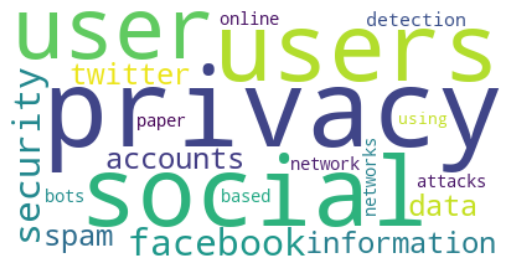

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#create a word cloud for topic 2

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=2)


## Reduce Outliers

### Overview

In [ ]:
def calculate_outliers(topic_list):
  count = 0
  for topic in topic_list:
    if topic == -1:
      count += 1
  return count

In [ ]:
# number of outliers in the "original model"
calculate_outliers(topics)

2123

There are different approached to reduce outliers (Topic -1). The "reduce_outliers" function allows the user to match outlier documents with their nearest topic using one of the following strategies:
* "probabilities"
            This uses the soft-clustering as performed by HDBSCAN to find the
            best matching topic for each outlier document. To use this, make
            sure to calculate the `probabilities` beforehand by instantiating
            BERTopic with `calculate_probabilities=True`.
* "distributions"
            Use the topic distributions, as calculated with `.approximate_distribution`
            to find the most frequent topic in each outlier document. You can use the
            `distributions_params` variable to tweak the parameters of
            `.approximate_distribution`.
* "c-tf-idf" - DEFAULT
            Calculate the c-TF-IDF representation for each outlier document and
            find the best matching c-TF-IDF topic representation using
            cosine similarity.
* "embeddings"
            Using the embeddings of each outlier documents, find the best
            matching topic embedding using cosine similarity.




Pros and Cons of Cosine Similarity: https://medium.com/@arjunprakash027/understanding-cosine-similarity-a-key-concept-in-data-science-72a0fcc57599

### Compute cosine similarity of two words that we consider similar in our context (for reference)

In [ ]:
# compute embeddings for security and privacy
embeddings_trial = embedding_model.encode(["security", "privacy"], show_progress_bar=True)

Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 91.61it/s]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# reshape arrays to match expected input shape of cosine_similarity
word1_embedding = embeddings_trial[0].reshape(1, -1)
word2_embedding = embeddings_trial[1].reshape(1, -1)


# compute cosine similarity
similarity = cosine_similarity(word1_embedding, word2_embedding)[0][0]
print(similarity)

0.7388516


In [ ]:
# What is a "good" number of outliers? Around 5%?
len(db)*0.05

609.3000000000001

**Note:**
* A good value for minimum cosine similarity is probably around 0.7/0.8
* A good number of outliers is probably around 600/700

Let's empirically explore it.



### Outlier Reduction: Probabilities

In [ ]:
# review parameter probs

probs[0]

array([0.00771456, 0.00952347, 0.01398504, 0.00859768, 0.00950503,
       0.01312866, 0.00862489, 0.01988338, 0.67403942, 0.00730734,
       0.01387914, 0.03827418, 0.00806659, 0.01408411, 0.00551097,
       0.00948551, 0.0061417 ])

In [ ]:
# threshold for assigning topics to outlier documents
# threshold = minimum probability when `strategy="probabilities"`
# threshold: default: 0 (no outliers)
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, strategy = "probabilities")

calculate_outliers(new_topics)

0

In [ ]:
# vary threshold: max 1 --> no change in outliers

new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, threshold = 1, strategy = "probabilities")

calculate_outliers(new_topics)

2123

In [ ]:
# FAVOURITE

# vary threshold (1/n; n = number of topics)
n = len(llama2_labels)
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, threshold = 1/n, strategy = "probabilities")

calculate_outliers(new_topics)

508

### Outlier Reduction Strategy: Topic Distributions

In [ ]:
# strategy = topic distributions; find the most frequent topic in each outlier document
# with this strategy, the threshold represents the minimum similarity

new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, strategy = "distributions")

calculate_outliers(new_topics)

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


0

In [ ]:
# threshold = 0.01
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, strategy = "distributions", threshold = 0.1)

calculate_outliers(new_topics)

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.62it/s]


2

In [ ]:
# threshold = 0.7
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, strategy = "distributions", threshold = 0.7)

calculate_outliers(new_topics)

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]


2123

In [ ]:
# threshold = 0.25
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, strategy = "distributions", threshold = 0.25)

calculate_outliers(new_topics)

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.66it/s]


597

**Note for the threshold value:**

* If the minimum cosine similarity as a threshold is 0, then all documents will be matched, no matter how far they are away in the vector space, i.e. how different they are.
* If the minimum cosine similarity as a threshold is 1, then now documents will be matched; all outliers remain the same, because outlier documents would only be matched, if they are very close to a topic -- which is by definition not the case, becuase they are outliers.

### Outlier Reduction: c-TF-IDF

In [ ]:
# strategy = c-tf-idf: calculate the c-tf-idf representation for each outlier document and find the best matching c-tf-idf representation using cosine similarity
# with this strategy, the threshold represents the minimum similarity

new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, strategy = "c-tf-idf")

calculate_outliers(new_topics)

0

In [ ]:
# vary threshold
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, threshold = 0.55,  strategy = "c-tf-idf")

calculate_outliers(new_topics)

2123

In [ ]:
# vary threshold
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, threshold = 0.7,  strategy = "c-tf-idf")

calculate_outliers(new_topics)

2123

In [ ]:
# vary threshold
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, threshold = 0.15,  strategy = "c-tf-idf")

calculate_outliers(new_topics)

724

### Outlier Reduction: Embeddings

In [ ]:
# strategy = embeddings: using the embedding of each outlier document, it finds the best matchin topic embedding using cosine similarity

# with this strategy, the threshold represents the minimum similarity

new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, strategy = "embeddings")

calculate_outliers(new_topics)

0

In [ ]:
# FAVOURITE

# vary threshold
new_topics = topic_model.reduce_outliers(abstracts, topics, probabilities = probs, threshold = 0.8, strategy = "embeddings")

calculate_outliers(new_topics)

347

### We use the embedding strategy with threshold 0.8 to move forward.

In [ ]:
# in case we need to reset topic model, run this cell to train again

# train model
#topics, probs = topic_model.fit_transform(abstracts, embeddings)
#topic_model.set_topic_labels(topic_labels=llama2_labels)

In [ ]:
# calculate new topics

new_topics = topic_model.reduce_outliers(abstracts, topics, threshold = 0.8, strategy = "embeddings")
calculate_outliers(new_topics)

347

In [ ]:
# update topic model with new topics

topic_model.update_topics(abstracts, topics=new_topics)

2024-04-23 22:34:51,096 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
# review the newly assigned topics

topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

In [ ]:
topic_model.visualize_topics()

### Visualization: Should we merge some topics?

In [ ]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

In [ ]:
# use our fitted BERTopic model to extract possible hierarchies from our c-TF-IDF matrix
hierarchical_topics = topic_model.hierarchical_topics(abstracts)

topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)

100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 238.13it/s]


### Manual review of topic labels and merging of topics

In [ ]:
# load trained topic model
#from bertopic import BERTopic

#topic_model = BERTopic.load("/home/das/Documents/OSN/BerTopic_28032024")

We apply the **dual reviewer system** (dual review of two authors/experts). We tune the hyperparameters and review of the results based on the two-dimensional visualization and the hierarchical clustering representation.

After the final hyper-parameter tuning, and reviewing the final results, we decide:

* **to not merge any topics.**
* **updating the following topic labels manually (only linguistic improvements):**
  * Topic 0: Knowledge Extraction
  * Topic 6: Sentiment Analysis
  
  
For Topic 4, please note the following: We keep this as a separate topic for Twitter since the focus lies on the analyis of Twitter, e.g. KeyBERT keywords: ['hashtags', 'hashtag', 'microblogging', 'twitter', 'clustering', 'social', 'tweet', 'tweets', 'trending', 'summarization']






In [ ]:
topic_model.set_topic_labels({0: "0-Knowledge Extraction", 6: "6-Sentiment Analysis"})

In [ ]:
topic_model.get_topic_info()

Topic  Count                          Name  \
0      -1    347              -1_the_and_of_to   
1       0   1563         0_the_wikipedia_of_to   
2       1   1264               1_the_of_and_to   
3       2   1140               2_the_of_to_and   
4       3   1012            3_the_image_of_and   
5       4    747         4_the_of_location_and   
6       5    829               5_the_of_to_and   
7       6    812        6_sentiment_the_of_and   
8       7    828             7_the_to_user_and   
9       8    565     8_the_of_networks_network   
10      9    420    9_learning_students_the_of   
11     10    569          10_and_the_of_social   
12     11    666              11_the_of_and_to   
13     12    352          12_and_the_of_health   
14     13    368              13_the_and_of_to   
15     14    252           14_covid_19_the_and   
16     15    238              15_the_and_of_to   
17     16    214  16_question_the_questions_to   

                                        CustomName  \
0                       -1-Social Network Analysis   
1                           0-Knowledge Extraction   
2                 1-Social Media and News Analysis   
3                    2-Online Privacy and Security   
4                    3-Image Tagging and Retrieval   
5         4-Location-Based Social Network Analysis   
6                                 5-Twitter Topics   
7                             6-Sentiment Analysis   
8                         7-Recommendation Systems   
9         8-Community Detection in Social Networks   
10             9-E-Learning and Student Engagement   
11  10-Social Media Usage and Marketing Strategies   
12   11-Social Influence and Information Diffusion   
13                       12-Public Health Analysis   
14          13-Social Media Accessibility Research   
15               14-Covid-19 Social Media Analysis   
16              15-Disaster Detection and Response   
17                           16-Question Answering   

                                       Representation  \
0       [the, and, of, to, data, in, for, is, we, on]   
1   [the, wikipedia, of, to, and, in, we, for, is,...   
2   [the, of, and, to, in, on, we, social, media, ...   
3   [the, of, to, and, in, privacy, we, that, soci...   
4   [the, image, of, and, images, to, in, we, is, ...   
5   [the, of, location, and, to, in, we, data, on,...   
6   [the, of, to, and, in, twitter, we, topic, is,...   
7   [sentiment, the, of, and, to, in, analysis, fo...   
8   [the, to, user, and, of, recommendation, in, u...   
9   [the, of, networks, network, and, in, social, ...   
10  [learning, students, the, of, and, to, in, moo...   
11  [and, the, of, social, to, in, facebook, on, t...   
12  [the, of, and, to, in, we, social, users, on, ...   
13  [and, the, of, health, to, in, we, drug, socia...   
14  [the, and, of, to, in, design, with, for, this...   
15  [covid, 19, the, and, pandemic, of, to, in, on...   
16  [the, and, of, to, in, disaster, information, ...   
17  [question, the, questions, to, answering, and,...   

                                              KeyBERT  \
0   [social, facebook, networks, popularity, linke...   
1   [wikipedia, semantic, disambiguation, dbpedia,...   
2   [twitter, facebook, cyberbullying, misinformat...   
3   [spam, spammers, social, attacks, bots, facebo...   
4   [tagging, flickr, similarity, tag, retrieval, ...   
5   [geotagged, geolocation, foursquare, social, g...   
6   [hashtags, microblogging, twitter, hashtag, tw...   
7   [sentiment, sentiments, classifiers, classifie...   
8   [recommender, recommending, recommendation, ra...   
9   [networks, clustering, graphs, nodes, graph, s...   
10  [learners, learner, learning, educational, tea...   
11  [facebook, social, influence, users, motivatio...   
12  [influencers, influence, networks, popularity,...   
13  [dataset, twitter, social, classification, dat...   
14  [facebook, social, usability, users, interacti...   
15  [coronavirus, pandemic, mi

In [ ]:
# review the newly assigned topics

topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=False, custom_labels=True)

## Assign topics to original database

In [ ]:
df_doc_topic = topic_model.get_document_info(abstracts)
df_doc_topic = df_doc_topic.rename(columns={'Document' : 'Abstract'})
df_doc_topic = df_doc_topic.rename(columns={'Topic' : 'Topic_Number'})
df_doc_topic = df_doc_topic.rename(columns={'CustomName' : 'Topic_Label'})
df_doc_topic.head(2)

Abstract  Topic_Number  \
0  Online social networks (OSNs) like Facebook, a...             8   
1  Online social network services (SNS) provide a...            10   

                        Name                                     Topic_Label  \
0  8_the_of_networks_network        8-Community Detection in Social Networks   
1       10_and_the_of_social  10-Social Media Usage and Marketing Strategies   

                                      Representation  \
0  [the, of, networks, network, and, in, social, ...   
1  [and, the, of, social, to, in, facebook, on, t...   

                                             KeyBERT  \
0  [networks, clustering, graphs, nodes, graph, s...   
1  [facebook, social, influence, users, motivatio...   

                                              Llama2  \
0  [Community Detection in Social Networks, , , ,...   
1  [Social Media Usage and Marketing Strategies, ...   

                                                 MMR  \
0  [networks, graph, social, graphs, nodes, commu...   
1  [social, facebook, users, instagram, marketing...   

                                 Representative_Docs  \
0  [Online social networks (OSNs) like Facebook, ...   
1  [This study examines the factors that affect c...   

                                         Top_n_words  Probability  \
0  the - of - networks - network - and - in - soc...     0.674039   
1  and - the - of - social - to - in - facebook -...     0.096860   

   Representative_document  
0                    False  
1                    False

In [ ]:
len(df_doc_topic)

12186

In [ ]:
updated_db = pd.merge(db, df_doc_topic[['Abstract', 'Topic_Number', 'Topic_Label']], on='Abstract', how='left')
updated_db.loc[updated_db['Topic_Number'] == -1, 'Topic_Label'] = 'Outlier'

In [ ]:
len(updated_db)

12186

In [ ]:
updated_db.head(2)

Authors  \
0  Symeonidis P.; Tiakas E.; Manolopoulos Y.   
1           Kisilevich S.; Ang C.S.; Last M.   

                                   Author full names  \
0  Symeonidis, Panagiotis (13006105800); Tiakas, ...   
1  Kisilevich, Slava (23392866000); Ang, Chee Sia...   

                            Author(s) ID  \
0  13006105800; 23668927700; 54397260800   
1   23392866000; 15831174100; 7005858141   

                                               Title  Year  \
0  Transitive node similarity for link prediction...  2010   
1  Large-scale analysis of self-disclosure patter...  2012   

                            Source title                        DOI  \
0  ACM Conference on Recommender Systems    10.1145/1864708.1864744   
1      Knowledge and Information Systems  10.1007/s10115-011-0443-z   

                                                Link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   

                                        Affiliations  \
0  Department of Informatics, Aristotle Universit...   
1  Department of Computer and Information Science...   

                           Authors with affiliations  \
0  Symeonidis P., Department of Informatics, Aris...   
1  Kisilevich S., Department of Computer and Info...   

                                            Abstract  \
0  Online social networks (OSNs) like Facebook, a...   
1  Online social network services (SNS) provide a...   

                                     Author Keywords Funding Details  \
0                        Algorithms; Experimentation             NaN   
1  Age differences; Clustering; Correspondence an...             NaN   

  Funding Texts Language of Original Document  \
0           NaN                       English   
1           NaN                       English   

                 Abbreviated Source Title                      OSN  \
0  RecSys - Proc. ACM Conf. Recomm. Syst.  ['Facebook', 'Myspace']   
1              Knowl. Inf. Systems. Syst.             ['Facebook']   

   Topic_Number                                     Topic_Label  
0             8        8-Community Detection in Social Networks  
1            10  10-Social Media Usage and Marketing Strategies

In [ ]:
updated_db.to_csv('minerva_osn.csv')

In [ ]:
#save final modified topic model
topic_model.save("BerTopic_date", serialization="pickle")

2024-04-23 23:02:24,609 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
